In [3]:
import os
from skimage import io, transform
from skimage import img_as_bool
import numpy as np
import matplotlib.pyplot as plt

import random

from PIL import Image
import copy
import time
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from visdom import Visdom

/home/chacko/.conda/envs/torch/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)
print(torch.cuda.current_device())

cuda:0
0


# Data Loader 

In [5]:
class PersonDataset(Dataset):
    
    def __init__(self, dataset_dir ,transform = None):
        """
        
        Args:
            dataset_dir : path to the dataset
            transform (callable, optional): Optional transform to be applied
                                            on a sample.
        """
        self.dataset_dir = dataset_dir
        self.list_dir = os.listdir(self.dataset_dir)
        self.transform = transform
        
    
    
    def __len__(self):
        return len(self.list_dir)
    
    def __getitem__(self,image_id):
        
        # read the image
        image_path  = (os.path.join(self.dataset_dir,self.list_dir[image_id],"images/{}.png".format(self.list_dir[image_id])))
        image = io.imread(image_path)
        # read the mask
        mask_dir = os.path.join(self.dataset_dir,self.list_dir[image_id],'masks')
        masks_list = []
        
        for i, f in enumerate (next(os.walk(mask_dir))[2]):
            if f.endswith ('.png'):
                m = io.imread(os.path.join(mask_dir,f)).astype(np.bool)
                m = m[:,:,0]
                masks_list.append(m)
                
                if len(masks_list) != 1:
                    masks = np.logical_or(masks,masks_list[i])
                else:
                    masks = masks_list[i]
                    
        
        sample = {"image":image,"masks":masks,"image_id":image_id}
        
        
        
        if self.transform:
            (image,masks) = sample["image"],sample["masks"]
            image = self.transform(image)
            masks = self.transform(masks.astype(np.int32))
            sample = {"image":image,"masks":masks,"image_id":image_id}
        
        return(sample)
        
        

In [43]:
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, masks_batch = sample_batched['image'].numpy(), sample_batched['masks'].numpy().astype(np.bool)
    batch_size = len(images_batch)
    for i in range(batch_size):
        plt.figure(num =None,figsize =(7,7),dpi =80)
        plt.subplot(1, 2, 1)
        plt.tight_layout()
        plt.imshow(images_batch[i].transpose((1, 2, 0)))
        plt.subplot(1, 2, 2)
        plt.tight_layout()
        plt.imshow(np.squeeze(masks_batch[i].transpose((1, 2, 0))))

1142
0 torch.Size([5, 3, 512, 512]) torch.Size([5, 1, 512, 512])
torch.int32


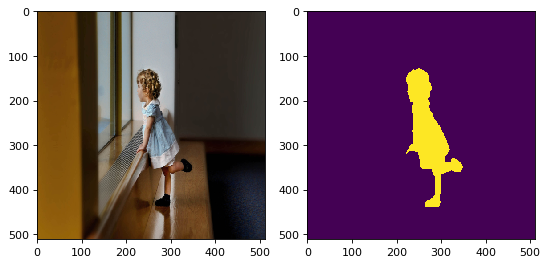

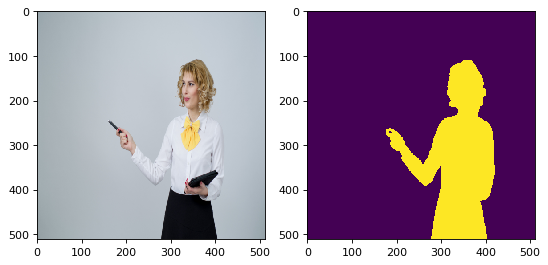

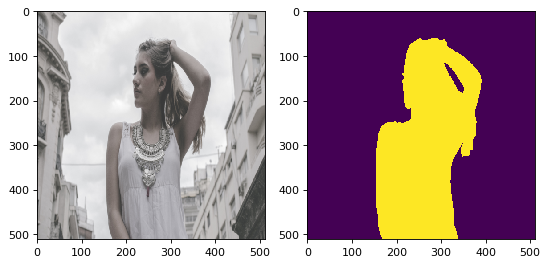

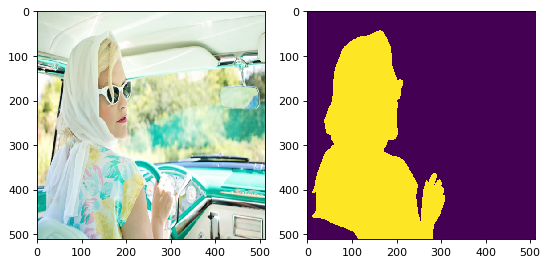

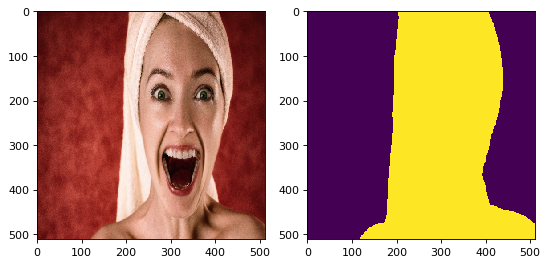

In [44]:
"""To check some whether Dataloader works fine """

# compose several transforms together
data_dir =  '/home/chacko/data/supervisely_person_data'
#data_dir =  '/home/robin/Thesis/Unet/data_test'
trans = transforms.Compose([transforms.ToPILImage(),transforms.Resize((512,512)) ,transforms.ToTensor()])
transformed_dataset = PersonDataset(data_dir,transform = trans)

dataloader = DataLoader(transformed_dataset, batch_size=5, shuffle=True, num_workers=0)
print(len(dataloader))
#check some samples from the data loader

for i_batch,sampled_batch in enumerate(dataloader):
    print(i_batch,sampled_batch['image'].size(),sampled_batch['masks'].size())
    print(sampled_batch["masks"].dtype)
    show_batch(sampled_batch)
    if i_batch ==0:
        break

# Train and Validation Dataloaders

In [14]:
#HyperParameters
train_batch_size = 4
val_batch_size   = 1
num_epochs = 100
learning_rate = 0.01            # 
num_classes = 2



In [15]:
# using pytorch "SUBSETRANDOMSAMPLER"

dataset = PersonDataset(data_dir,transform = trans)
validation_split = .3
shuffle_dataset = True
random_seed= 42


# create indices for training and validation splits.

dataset_size  = len(dataset)
# we create the indices using python range function and store it into a list
indices = list(range(dataset_size))
split = int(np.floor(validation_split*dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices,val_indices = indices[split:],indices[:split]
# create dataloaders...
train_sampler = SubsetRandomSampler(train_indices)
val_sampler   = SubsetRandomSampler(val_indices)

train_loader  = DataLoader(dataset, batch_size=train_batch_size, shuffle=False, num_workers=0,sampler = train_sampler)
val_loader  = DataLoader(dataset, batch_size=val_batch_size, shuffle=False, num_workers=0,sampler = val_sampler)

# dictionary for data loaders..
dataloaders = {"train" :train_loader,
              "val":val_loader
              }



# UNet Module

In [16]:
class Unet(nn.Module):
    
    
    def contract_block(self,in_ch,out_ch):
        
 
        block = nn.Sequential(
                nn.Conv2d(in_ch,out_ch,kernel_size=3,padding = 1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_ch),
                nn.Conv2d(out_ch,out_ch,kernel_size=3,padding = 1),               
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_ch)
                )
        return block
    
    def expansive_block(self,in_ch ,mid_ch ,out_ch):
        
  
        block = nn.Sequential(
                nn.Conv2d(in_ch,mid_ch,kernel_size=3,padding = 1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(mid_ch),
                nn.Conv2d(mid_ch,mid_ch,kernel_size=3,padding = 1),               
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(mid_ch),
                nn.ConvTranspose2d(mid_ch,out_ch,kernel_size = 3,stride = 2,padding = 1,output_padding = 1)
                )
                
        return block
    
    def final_block(self, in_ch, mid_ch , out_ch):
       
        block = nn.Sequential(
                nn.Conv2d(in_ch,mid_ch,kernel_size=3,padding = 1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(mid_ch),
                nn.Conv2d(mid_ch,mid_ch,kernel_size=3,padding = 1),               
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(mid_ch),
                nn.Conv2d(mid_ch,out_ch,kernel_size=3,padding=1)
                )
        return block
    
    
    
    def __init__(self,in_channel,no_classes):
        super (Unet,self).__init__()
        # encode part
        self.conv_encode1 = self.contract_block(in_ch = in_channel,out_ch = 64)
        self.downsample1  = nn.MaxPool2d(kernel_size = 2)
        self.conv_encode2 = self.contract_block(in_ch = 64 ,out_ch = 128)
        self.downsample2  = nn.MaxPool2d(kernel_size = 2)
        self.conv_encode3 = self.contract_block(in_ch = 128 ,out_ch = 256)
        self.downsample3  = nn.MaxPool2d(kernel_size = 2)
        self.conv_encode4 = self.contract_block(in_ch = 256 ,out_ch = 512)
        self.downsample4  = nn.MaxPool2d(kernel_size = 2)
        
        
        # bottle neck part
        self.bottleneck = nn.Sequential(
                          nn.Conv2d(512,1024,kernel_size=3,padding= 1),
                          nn.ReLU(inplace=True),
                          nn.BatchNorm2d(1024),
                          nn.Conv2d(1024,1024,kernel_size=3,padding = 1),               
                          nn.ReLU(inplace=True),
                          nn.BatchNorm2d(1024),
                          nn.ConvTranspose2d(1024,512,kernel_size = 3,stride = 2,padding = 1,output_padding = 1)
                            )
        
        # decode part
        self.conv_decode4 = self.expansive_block(in_ch = 1024,mid_ch = 512 ,out_ch = 256) 
        self.conv_decode3 = self.expansive_block(in_ch = 512,mid_ch = 256 ,out_ch = 128)
        self.conv_decode2 = self.expansive_block(in_ch = 256,mid_ch = 128 ,out_ch = 64)
        self.final_layer  = self.final_block(in_ch = 128,mid_ch = 64 ,out_ch = no_classes)
        
    
    def crop_and_concat(self,upsampled,bypass,crop = False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass,(-c,-c,-c,-c))
        
        else:
            return torch.cat((upsampled,bypass),1) # concatenate along column dimension
        
    def forward(self,x):
            # encode
            
            encode_layer1 = self.conv_encode1(x)
            encode_pool1  = self.downsample1(encode_layer1)
           
            encode_layer2 = self.conv_encode2(encode_pool1 )
            encode_pool2  = self.downsample2(encode_layer2)
            
            encode_layer3 = self.conv_encode3(encode_pool2 )
            encode_pool3  = self.downsample3(encode_layer3)
            
            encode_layer4 = self.conv_encode4(encode_pool3 )
            encode_pool4  = self.downsample3(encode_layer4)
            
            # Bottleneck
            
            bottleneck = self.bottleneck(encode_pool4)
            
            ##print("bottleneck size {}".format(bottleneck.shape),"encode_layer3 {}".format(encode_layer3.shape))
            
            # Decode
            skip_connection1 = self.crop_and_concat(bottleneck,encode_layer4,crop=False)
            decode_layer4    = self.conv_decode4(skip_connection1)
            
            skip_connection2 = self.crop_and_concat(decode_layer4,encode_layer3, crop=False)
            decode_layer3    = self.conv_decode3(skip_connection2)
            
            skip_connection3 = self.crop_and_concat(decode_layer3,encode_layer2,crop=False)
            decode_layer2    = self.conv_decode2(skip_connection3)
            
            skip_connection4 = self.crop_and_concat(decode_layer2,encode_layer1,crop =False)
            final_layer      = self.final_layer(skip_connection4)
             
           
            return final_layer

In [56]:
def show_prediction(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, gt_masks_batch,pred_masks_batch = sample_batched['image'].numpy(),sample_batched['gt_masks'].numpy().astype(np.bool),sample_batched['pred_masks'].numpy().astype(np.bool)
    batch_size = len(images_batch)
    for i in range(batch_size):
        plt.figure(num =None,figsize =(10,10),dpi =80)
        plt.subplot(1, 3, 1)
        plt.tight_layout()
        plt.imshow(images_batch[i].transpose((1, 2, 0)))
        plt.subplot(1, 3, 2)
        plt.tight_layout()
        plt.imshow(np.squeeze(gt_masks_batch[i].transpose((1, 2, 0))))
        plt.subplot(1, 3, 3)
        plt.tight_layout()
        plt.imshow(np.squeeze(pred_masks_batch[i].transpose((1, 2, 0))))



In [66]:
def show_prediction(sample_batched):
    """Show image with landmarks and predicted masks for a batch of samples."""
    images_batch, gt_masks_batch,pred_masks_batch = sample_batched['image'].numpy(),sample_batched['gt_masks'].numpy().astype(np.bool),sample_batched['pred_masks'].numpy().astype(np.bool)
    batch_size = len(images_batch)
    for i in range(batch_size):
        fig = plt.figure(num =None,figsize =(10,10),dpi =80)
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_title("Image")
        plt.imshow(images_batch[i].transpose((1, 2, 0)))
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title("GT mask")
        plt.imshow(np.squeeze(gt_masks_batch[i].transpose((1, 2, 0))))
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title("Predicted mask")
        plt.imshow(np.squeeze(pred_masks_batch[i].transpose((1, 2, 0))))
        plt.show()


/home/chacko


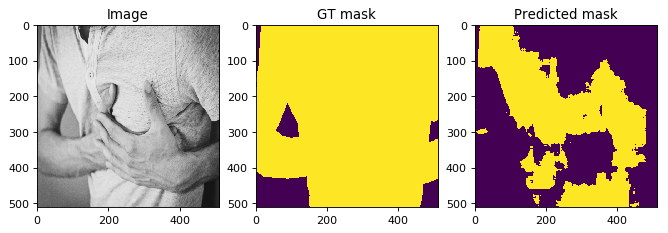

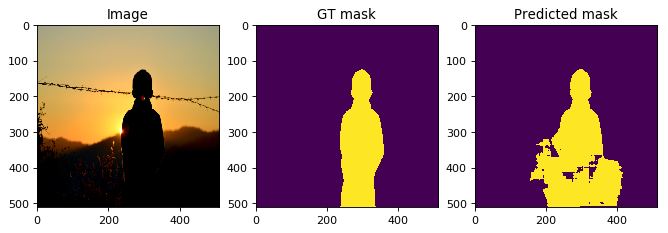

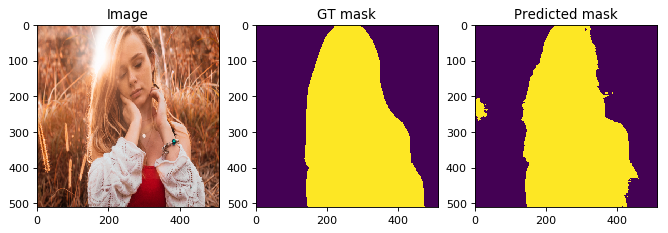

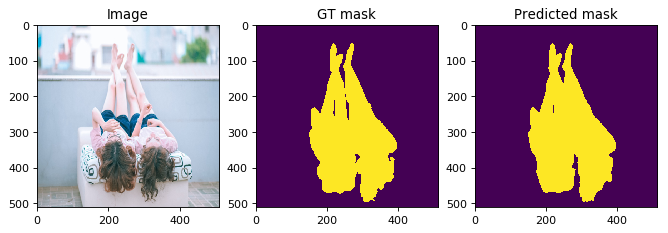

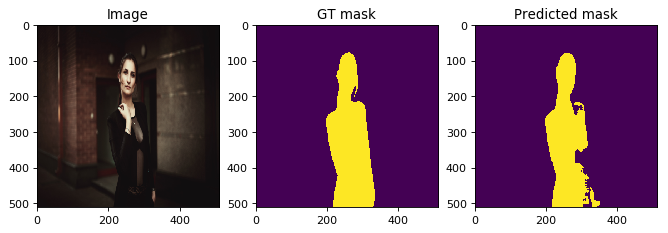

In [71]:

print(os.getcwd())
# load the model
logs_path = '/home/chacko/train_exp3-epoch65.pth'
model = Unet(3,num_classes)
if torch.cuda.device_count()>1:
    model = nn.DataParallel(model,device_ids = [0,1])
model.to(device)
optimizer = optim.SGD(model.parameters(),
                          lr=0.01,
                          momentum=0.9,
                          weight_decay=0.0005)
checkpoint = torch.load(logs_path)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.eval()
for index,sampled_batch in enumerate (val_loader,0):
        
        inputs = sampled_batch["image"] # N,C,H,W
        labels_pre = sampled_batch["masks"]  # N,C,H.W
        labels = torch.squeeze(labels,1).long() # N,H,W
        pred = model(inputs)
        _,predicted = torch.max(pred,1)
        predicted =torch.unsqueeze(predicted,1)
        sample = {"image":inputs.cpu(),"gt_masks":labels_pre.cpu(),"pred_masks":predicted.cpu()}
        show_prediction(sample)
        if index ==4:
            break
        
        


In [13]:
print(torch.cuda.device_count())

4
